In [1]:
# Import required libraries and define dataset paths

import os
from glob import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split

DATA_ROOT = "../data"

# Define subdirectory paths
TRAIN_FLOODED_IMG = os.path.join(DATA_ROOT, "Train/Labeled/Flooded/image")
TRAIN_FLOODED_MASK = os.path.join(DATA_ROOT, "Train/Labeled/Flooded/mask")

TRAIN_NONFLOODED_IMG = os.path.join(DATA_ROOT, "Train/Labeled/Non-Flooded/image")
TRAIN_NONFLOODED_MASK = os.path.join(DATA_ROOT, "Train/Labeled/Non-Flooded/mask")

In [2]:
# Load image and mask file paths

train_images = sorted(
    glob(os.path.join(TRAIN_FLOODED_IMG, "*.jpg")) +
    glob(os.path.join(TRAIN_NONFLOODED_IMG, "*.jpg"))
)

train_masks = sorted(
    glob(os.path.join(TRAIN_FLOODED_MASK, "*.png")) +
    glob(os.path.join(TRAIN_NONFLOODED_MASK, "*.png"))
)

print("Total labeled images:", len(train_images))
print("Total labeled masks :", len(train_masks))

Total labeled images: 398
Total labeled masks : 398


In [3]:
# Split labeled dataset into training and validation sets (80/20 split)

train_imgs_split, val_imgs_split, train_masks_split, val_masks_split = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)

print("Training images:", len(train_imgs_split))
print("Validation images:", len(val_imgs_split))

Training images: 318
Validation images: 80


In [4]:
# Resize images, convert to tensor, and scale to [0,1]
# Masks use nearest-neighbor interpolation and integer labels

import torchvision.transforms.functional as TF
import torch

IMG_SIZE = 512

def preprocess_image(img):
    img = TF.resize(img, (IMG_SIZE, IMG_SIZE))
    img = TF.to_tensor(img)
    return img

def preprocess_mask(mask):
    mask = TF.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=TF.InterpolationMode.NEAREST)
    mask = torch.from_numpy(np.array(mask)).long()
    return mask

In [5]:
# Simple augmentation: horizontal and vertical flips

def augment(img, mask):
    if random.random() > 0.5:
        img = TF.hflip(img)
        mask = torch.flip(mask, dims=[1])
    if random.random() > 0.5:
        img = TF.vflip(img)
        mask = torch.flip(mask, dims=[0])
    return img, mask

In [6]:
# Test preprocessing on one sample image-mask pair

idx = random.randint(0, len(train_imgs_split)-1)

img_raw = Image.open(train_imgs_split[idx])
mask_raw = Image.open(train_masks_split[idx])

img_p = preprocess_image(img_raw)
mask_p = preprocess_mask(mask_raw)

print("Image shape after preprocessing:", img_p.shape)
print("Mask shape after preprocessing:", mask_p.shape)

Image shape after preprocessing: torch.Size([3, 512, 512])
Mask shape after preprocessing: torch.Size([512, 512])


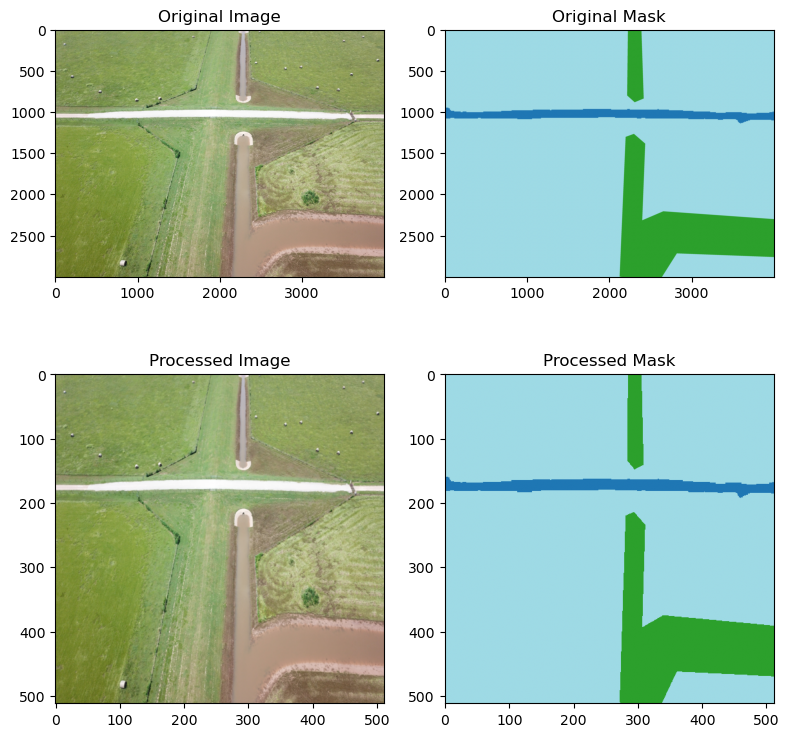

In [7]:
# Compare original and resized+normalized images

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0][0].imshow(img_raw)
ax[0][0].set_title("Original Image")

ax[0][1].imshow(mask_raw, cmap='tab20')
ax[0][1].set_title("Original Mask")

ax[1][0].imshow(img_p.permute(1,2,0))
ax[1][0].set_title("Processed Image")

ax[1][1].imshow(mask_p, cmap='tab20')
ax[1][1].set_title("Processed Mask")

plt.tight_layout()
plt.show()

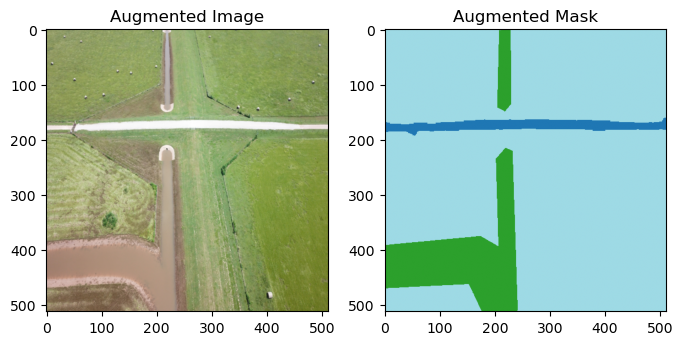

In [8]:
# Apply augmentation and visualize results

img_aug, mask_aug = augment(img_p.clone(), mask_p.clone())

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img_aug.permute(1,2,0))
ax[0].set_title("Augmented Image")
ax[1].imshow(mask_aug, cmap='tab20')
ax[1].set_title("Augmented Mask")
plt.show()

In [9]:
# Preprocessing summary

# - Performed train-validation split on labeled FloodNet dataset
# - Resized all samples to 512x512 for training efficiency
# - Converted images to tensors and normalized to [0,1]
# - Applied basic data augmentation (horizontal and vertical flips)
# - Verified preprocessing and augmentation visually
# Next: build dataset class and dataloader for training

# Next steps in the project

# 1. Implement a PyTorch Dataset class to load images and masks dynamically
# 2. Create DataLoader objects for efficient mini-batch training
# 3. Define the UNet architecture for semantic segmentation
# 4. Configure loss function (CrossEntropyLoss for 10 classes) and optimizer
# 5. Train the model on preprocessed and augmented data
# 6. Evaluate performance using IoU and Dice score
# 7. Visualize predictions and compare with ground truth masks
